# MyAnimeList 2025: EDA and Popularity Prediction

### Introduction

This notebook uses the MyAnimeList 2025 dataset to examine factors associated with anime popularity. The analysis focuses on the `Members` variable, which reflects the number of users who have added a title to their personal list. Since users make this choice intentionally, the value serves as a practical indicator of audience size and visibility.

A secondary aim is to apply a predictive model to **Medalist**, a series that has gained significant attention despite modest initial expectations and a personal favorite of mine. As of December 8, 2025, Season 1 of Medalist has 75,291 Members. This level of engagement suggests a breakout success. The goal of the model is to estimate what Member count the metadata alone would have predicted, and to provide a baseline estimate for future seasons.

Dataset: https://www.kaggle.com/datasets/syahrulapriansyah2/myanimelist-2025

Github: https://github.com/cnnadi123/mal-predictions-project

Goal:
- Clean and explore the dataset.
- Build a model to predict how many members (`Members`) an anime will have, using basic metadata.
- Use the model to estimate the popularity of **Medalist**.


In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df= pd.read_csv('mal_anime.csv')
df.head()

,myanimelist_id,title,description,image,Type,Episodes,Status,Premiered,Released_Season,Released_Year,...,Demographic,Duration,Rating,Score,Ranked,Popularity,Members,Favorites,characters,source_url
0,1,Cowboy Bebop,"Crime is timeless. By the year 2071, humanity ...",https://cdn.myanimelist.net/images/anime/4/196...,TV,26,Finished Airing,Spring 1998,Spring,1998.0,...,NaN,24 min. per ep.,R - 17+ (violence & profanity),8.75,#48,#42,"2,008,019","87,916","[{""id"": 3, ""name"": ""Black, Jet"", ""url"": ""https...",https://myanimelist.net/anime/1/Cowboy_Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,"Another day, another bounty—such is the life o...",https://cdn.myanimelist.net/images/anime/1439/...,Movie,1.0,Finished Airing,NaN,NaN,NaN,...,NaN,1 hr. 55 min.,R - 17+ (violence & profanity),8.38,#232,#649,"403,604","1,748","[{""id"": 3, ""name"": ""Black, Jet"", ""url"": ""https...",https://myanimelist.net/anime/5/Cowboy_Bebop__...
2,6,Trigun,"Vash the Stampede is the man with a $$60,000,0...",https://cdn.myanimelist.net/images/anime/1130/...,TV,26,Finished Airing,Spring 1998,Spring,1998.0,...,Shounen,24 min. per ep.,PG-13 - Teens 13 or older,8.22,#385,#265,"815,140","17,193","[{""id"": 713, ""name"": ""Stryfe, Meryl"", ""url"": ""...",https://myanimelist.net/anime/6/Trigun
3,7,Witch Hunter Robin,"Though hidden away from the general public, Wi...",https://cdn.myanimelist.net/images/anime/10/19...,TV,26.0,Finished Airing,Summer 2002,Summer,2002.0,...,NaN,25 min. per ep.,PG-13 - Teens 13 or older,7.23,#3344,#1979,"125,868",686,"[{""id"": 300, ""name"": ""Amon"", ""url"": ""https://m...",https://myanimelist.net/anime/7/Witch_Hunter_R...
4,8,Bouken Ou Beet,It is the dark century and the people are suff...,https://cdn.myanimelist.net/images/anime/7/215...,TV,52,Finished Airing,Fall 2004,Fall,2004.0,...,Shounen,23 min. per ep.,PG - Children,6.92,#4887,#5765,"16,456",18,"[{""id"": 9054, ""name"": ""Beet"", ""url"": ""https://...",https://myanimelist.net/anime/8/Bouken_Ou_Beet


### Initial inspection

Before modeling, it is important to understand the structure of the dataset. This includes identifying missing values, irregular formatting, and fields that require transformation. A stable and consistent dataset helps the model learn meaningful patterns instead of just reacting to noise.


In [20]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19931 entries, 0 to 19930
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   myanimelist_id   19931 non-null  int64  
 1   title            19931 non-null  object 
 2   description      19875 non-null  object 
 3   image            19544 non-null  object 
 4   Type             19534 non-null  object 
 5   Episodes         19549 non-null  object 
 6   Status           19549 non-null  object 
 7   Premiered        6343 non-null   object 
 8   Released_Season  6182 non-null   object 
 9   Released_Year    6182 non-null   float64
 10  Source           19166 non-null  object 
 11  Genres           18270 non-null  object 
 12  Themes           11217 non-null  object 
 13  Studios          19549 non-null  object 
 14  Producers        19549 non-null  object 
 15  Demographic      6522 non-null   object 
 16  Duration         19549 non-null  object 
 17  Rating      

myanimelist_id         0
title                  0
description           56
image                387
Type                 397
Episodes             382
Status               382
Premiered          13588
Released_Season    13749
Released_Year      13749
Source               765
Genres              1661
Themes              8714
Studios              382
Producers            382
Demographic        13409
Duration             382
Rating               874
Score               4692
Ranked              2525
Popularity           382
Members              382
Favorites            382
characters          6412
source_url             0
dtype: int64

### Cleaning studio related fields

Studio information is often relevant to audience expectations and production trends. The raw dataset contains a frequent placeholder called `"add some"` and inconsistent formatting, so the first cleaning steps focus on removing invalid values and reconstructing a reliable simplified studio category.

A new `Studio_Simplified` field is created by identifying studios with at least one hundred shows. These studios receive their own label. All remaining studios are grouped together as `Other`. This approach preserves meaningful distinctions while avoiding unnecessary fragmentation.

We:
- Remove the string `"add some"` wherever it appears.
- Drop the original `Studio` field.
- Build a cleaner `Studio_Simplified` based on studio frequency (>= 100 titles).


In [21]:
df_clean= df.copy()

#Remove invalid strings in studio related columns
for col in ["Studios", "Producers", "Studio_Simplified"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.replace("add some", "", case=False)
        df_clean[col] = df_clean[col].str.strip().replace("", np.nan)

#Drop unreliable Studio_Simplified from original dataset
if "Studio_Simplified" in df_clean.columns:
    df_clean = df_clean.drop(columns=["Studio_Simplified"])

#Build new simplified studio field based on frequency
studio_counts= (
    df_clean["Studios"]
    .fillna("")
    .str.split(",")
    .explode()
    .str.strip()
)

studio_counts = studio_counts[studio_counts != ""]
studio_freq = studio_counts.value_counts()

#Keep studios that appear frequently enough
keep_studios = set(studio_freq[studio_freq>= 100].index)

def simplify_studios(studio_str):
    if pd.isna(studio_str) or studio_str.strip()== "":
        return "Other"
    studios= [s.strip() for s in studio_str.split(",")]
    for s in studios:
        if s in keep_studios:
            return s
    return "Other"

df_clean["Studio_Simplified"] = df_clean["Studios"].apply(simplify_studios)
df_clean["Studio_Simplified"] = df_clean["Studio_Simplified"].fillna("Other")

df_clean["Studio_Simplified"].value_counts().head(20)

Studio_Simplified
Other                   12913
Toei Animation            825
Sunrise                   535
J.C.Staff                 428
nan                       382
TMS Entertainment         375
Madhouse                  351
Production I.G            326
Studio Deen               300
OLM                       282
Studio Pierrot            268
Shin-Ei Animation         259
A-1 Pictures              229
Nippon Animation          218
DLE                       199
AIC                       182
Tatsunoko Production      171
Bones                     154
T-Rex                     143
Gonzo                     136
Name: count, dtype: int64

### Cleaning and filtering the target variable

The `Members` column is what we will be predicting on. It is cleaned to remove comma formatting and converted to a numeric type. Rows with zero or missing values are removed because they do not represent actual audience engagement.

Columns that contain information generated after release, such as scores and rankings, are removed. These fields would artificially improve predictive accuracy, since they reflect audience reactions rather than metadata available before release.

We want to:
- Remove commas and convert to numeric.
- Drop rows where `Members` is missing or non-positive.
- Drop columns that leak information or are not useful for this model:
  - Text columns (e.g. `title`, `description`, `image`, `characters`, `source_url`)
  - Score / rank / popularity fields (`Score`, `Ranked`, `Popularity`, `Favorites`)
  - Some status columns like `Status`, `Premiered`, `Producers`
- Restrict to rows with valid `Released_Season` and `Released_Year`.

In [22]:
#Clean Members field
df_clean["Members"]= df_clean["Members"].astype(str).str.replace(",", "", regex=True)
df_clean["Members"]= pd.to_numeric(df_clean["Members"], errors="coerce")

#Keep only entries with positive member counts
df_clean= df_clean[df_clean["Members"] > 0]

#Drop text heavy and leakage columns
cols_to_drop= [
    "title", "description", "image", "characters", "source_url",
    "Score", "Ranked", "Popularity", "Favorites",
    "Producers", "Status", "Premiered"
]

cols_to_drop= [c for c in cols_to_drop if c in df_clean.columns]
df_clean= df_clean.drop(columns=cols_to_drop)

#Keep only rows with valid season and year information
df_clean= df_clean[
    df_clean["Released_Season"].notna() &
    df_clean["Released_Year"].notna()
]

df_clean.info()
df_clean.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 6182 entries, 0 to 19929
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   myanimelist_id     6182 non-null   int64  
 1   Type               6182 non-null   object 
 2   Episodes           6182 non-null   object 
 3   Released_Season    6182 non-null   object 
 4   Released_Year      6182 non-null   float64
 5   Source             6087 non-null   object 
 6   Genres             5794 non-null   object 
 7   Themes             4268 non-null   object 
 8   Studios            5432 non-null   object 
 9   Demographic        2705 non-null   object 
 10  Duration           6182 non-null   object 
 11  Rating             6068 non-null   object 
 12  Members            6182 non-null   float64
 13  Studio_Simplified  6182 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 724.5+ KB


myanimelist_id          0
Type                    0
Episodes                0
Released_Season         0
Released_Year           0
Source                 95
Genres                388
Themes               1914
Studios               750
Demographic          3477
Duration                0
Rating                114
Members                 0
Studio_Simplified       0
dtype: int64

### Converting and normalizing numeric and categorical fields

Many categorical fields such as Genres, Themes, Rating, and Season require standardization. Missing values are filled, and inconsistent capitalization is corrected. Duration values are converted to minutes so they can be treated as numeric features. These steps ensure that the categorical and numeric fields are structured in a form that the model can interpret reliably.

We:
- Convert `Episodes` to numeric.
- Optionally parse `Duration` to minutes.
- Fill missing categorical values with `"Unknown"` or `"Other"`.
- Normalize casing and whitespace.

In [23]:
#Convert Episodes to numeric
df_clean["Episodes"]= pd.to_numeric(df_clean["Episodes"], errors="coerce")

#Parse Duration into minutes
def parse_duration(x):
    if pd.isna(x):
        return np.nan
    x= str(x).lower()
    nums= re.findall(r"\d+", x)
    nums= list(map(int, nums)) if nums else []
    if "hr" in x and "min" in x and len(nums)>= 2:
        return nums[0] * 60 + nums[1]
    if "hr" in x and len(nums)>= 1:
        return nums[0] * 60
    if "min" in x and len(nums)>= 1:
        return nums[0]
    return np.nan

df_clean["Duration_Minutes"]= df_clean["Duration"].apply(parse_duration)
df_clean= df_clean.drop(columns=["Duration"])

#Fill missing categoricals and normalize
df_clean["Source"]= df_clean["Source"].fillna("Unknown")
df_clean["Genres"]= df_clean["Genres"].fillna("")
df_clean["Themes"]= df_clean["Themes"].fillna("")
df_clean["Demographic"]= df_clean["Demographic"].fillna("Unknown")
df_clean["Rating"]= df_clean["Rating"].fillna("Unknown")

df_clean["Released_Season"]= df_clean["Released_Season"].astype(str).str.title()
df_clean["Type"]= df_clean["Type"].astype(str).str.title()
df_clean["Source"]= df_clean["Source"].astype(str).str.strip().str.title()
df_clean["Demographic"]= df_clean["Demographic"].astype(str).str.strip().str.title()
df_clean["Studio_Simplified"]= df_clean["Studio_Simplified"].astype(str)

df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6182 entries, 0 to 19929
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   myanimelist_id     6182 non-null   int64  
 1   Type               6182 non-null   object 
 2   Episodes           6023 non-null   float64
 3   Released_Season    6182 non-null   object 
 4   Released_Year      6182 non-null   float64
 5   Source             6182 non-null   object 
 6   Genres             6182 non-null   object 
 7   Themes             6182 non-null   object 
 8   Studios            5432 non-null   object 
 9   Demographic        6182 non-null   object 
 10  Rating             6182 non-null   object 
 11  Members            6182 non-null   float64
 12  Studio_Simplified  6182 non-null   object 
 13  Duration_Minutes   6050 non-null   float64
dtypes: float64(4), int64(1), object(9)
memory usage: 724.5+ KB


,myanimelist_id,Type,Episodes,Released_Season,Released_Year,Source,Genres,Themes,Studios,Demographic,Rating,Members,Studio_Simplified,Duration_Minutes
0,1,Tv,26.0,Spring,1998.0,Original,"Action, Award Winning, Sci-Fi","Adult Cast, Space",Sunrise,Unknown,R - 17+ (violence & profanity),2008019.0,Sunrise,24.0
2,6,Tv,26.0,Spring,1998.0,Manga,"Action, Adventure, Sci-Fi",Adult Cast,Madhouse,Shounen,PG-13 - Teens 13 or older,815140.0,Madhouse,24.0
3,7,Tv,26.0,Summer,2002.0,Original,"Action, Drama, Mystery, Supernatural",Detective,Sunrise,Unknown,PG-13 - Teens 13 or older,125868.0,Sunrise,25.0
4,8,Tv,52.0,Fall,2004.0,Manga,"Action, Adventure, Fantasy",,Toei Animation,Shounen,PG - Children,16456.0,Toei Animation,23.0
5,15,Tv,145.0,Spring,2005.0,Manga,Sports,Team Sports,Gallop,Shounen,PG-13 - Teens 13 or older,193542.0,Other,23.0


### Exploratory data analysis of Members

The distribution of `Members` is heavily right skewed. Most shows attract modest attention, while a smaller number achieve very high visibility. A logarithmic transformation produces a smoother distribution and supports more stable modeling.


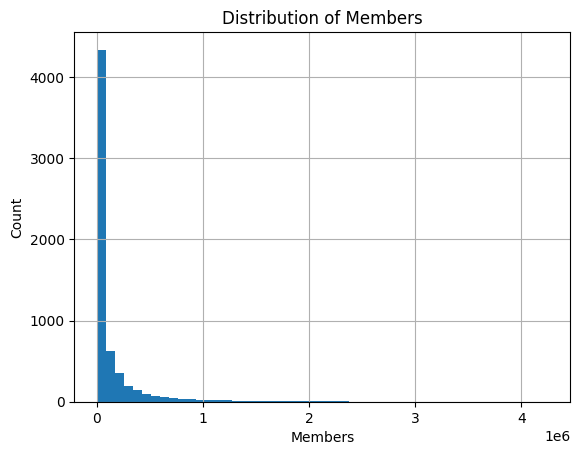

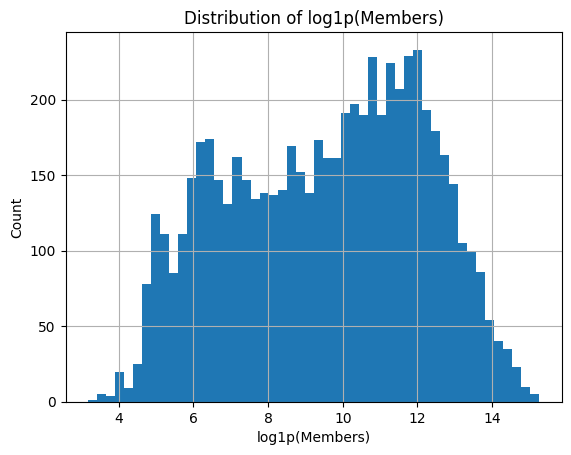

In [24]:
plt.figure()
df_clean["Members"].hist(bins= 50)
plt.xlabel("Members")
plt.ylabel("Count")
plt.title("Distribution of Members")
plt.show()

plt.figure()
np.log1p(df_clean["Members"]).hist(bins= 50)
plt.xlabel("log1p(Members)")
plt.ylabel("Count")
plt.title("Distribution of log1p(Members)")
plt.show()

### Type and season overview

It is helpful to see how many entries fall into each Type and Released_Season category to understand the overall structure of the dataset.


In [25]:
df_clean["Type"].value_counts()
df_clean["Released_Season"].value_counts()

Released_Season
Spring    1944
Fall      1796
Winter    1298
Summer    1144
Name: count, dtype: int64

### Preparing the modeling dataset

The next step is to one hot encode the categorical variables, create dummy variables for multi label fields such as Genres and Themes, and prepare the numerical features. Episodes are imputed by the median within each Type to preserve internal consistency.

We:
- Copy `df_clean` into `df_model`.
- Drop raw `Studios` (since we already have `Studio_Simplified`).
- Build the target as `y = log1p(Members)`.
- Impute missing `Episodes` by median within each `Type`.
- Cast `Released_Year` to integer.
- Build dummy variables for:
  - Categorical columns: `Type`, `Released_Season`, `Source`, `Demographic`, `Rating`, `Studio_Simplified`.
  - Multi-label text fields: `Genres`, `Themes`.
- Combine everything into a single `X` matrix.

In [26]:
df_model= df_clean.copy()

#Drop raw Studios column to avoid redundancy with Studio_Simplified.
if "Studios" in df_model.columns:
    df_model= df_model.drop(columns=["Studios"])

#Target variable: log transformed Members.
y= np.log1p(df_model["Members"])

#Impute Episodes by median per Type.
df_model["Episodes"]= df_model["Episodes"].astype(float)
df_model["Episodes"]= df_model.groupby("Type")["Episodes"].transform(
    lambda s: s.fillna(s.median())
)

#Ensure Released_Year is an integer.
df_model["Released_Year"]= df_model["Released_Year"].astype(int)

#One hot encoding for Genres and Themes.
genres_dummies= df_model["Genres"].str.get_dummies(sep=",")
genres_dummies.columns= [c.strip() for c in genres_dummies.columns]

themes_dummies = df_model["Themes"].str.get_dummies(sep=",")
themes_dummies.columns= [c.strip() for c in themes_dummies.columns]

#One hot encoding for standard categorical fields.
cat_cols= ["Type", "Released_Season", "Source", "Demographic", "Rating", "Studio_Simplified"]
cats_dummies= pd.get_dummies(df_model[cat_cols], drop_first=False)

#Numeric features
numeric_cols= ["Episodes", "Released_Year", "Duration_Minutes"]
X_numeric= df_model[numeric_cols]

#Final feature matrix
X= pd.concat([X_numeric, cats_dummies, genres_dummies, themes_dummies], axis=1)

#Sanity check for stray placeholder text
[col for col in X.columns if "add" in col.lower()], X.shape

([], (6182, 207))

### Model selection and training

A Random Forest Regressor is selected for this analysis. This model handles nonlinear relationships and performs well with a mix of numeric and categorical indicators. Since anime metadata contains complex interactions, this model is suitable for learning patterns without requiring strong parametric assumptions.


In [27]:
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf= RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model evaluation

The trained model is evaluated on the test set. The R² score indicates how much of the variation in the log transformed Members variable is explained by the model. The RMSE on the log scale provides an interpretable measure of error in the transformed space.


In [28]:
y_pred= rf.predict(X_test)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))
r2= r2_score(y_test, y_pred)

print(f"RMSE (log1p scale): {rmse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE (log1p scale): 0.9672
R^2: 0.8548


### Feature importance

The most influential features include demographic tags, release year, rating classifications, and studio grouping. These results suggest that the target audience, timing, and production source consistently shape the visibility of a title. Genre features also contribute, although their influence is more diffuse across many individual tags.


In [29]:
importances= pd.Series(rf.feature_importances_, index=X.columns)
top_n= 20
top_importances= importances.sort_values(ascending=False).head(top_n)
top_importances

Demographic_Kids                         0.263083
Duration_Minutes                         0.232644
Released_Year                            0.166567
Episodes                                 0.034350
Rating_G - All Ages                      0.033410
Rating_PG - Children                     0.026906
Studio_Simplified_Other                  0.020005
Demographic_Unknown                      0.015090
Source_Unknown                           0.014320
Rating_R - 17+ (violence & profanity)    0.008528
Source_Light Novel                       0.007628
Romance                                  0.007051
Comedy                                   0.004708
Source_Original                          0.004612
Source_Manga                             0.004087
Action                                   0.004074
Source_Game                              0.004038
Demographic_Shounen                      0.004005
School                                   0.003438
Released_Season_Fall                     0.003408


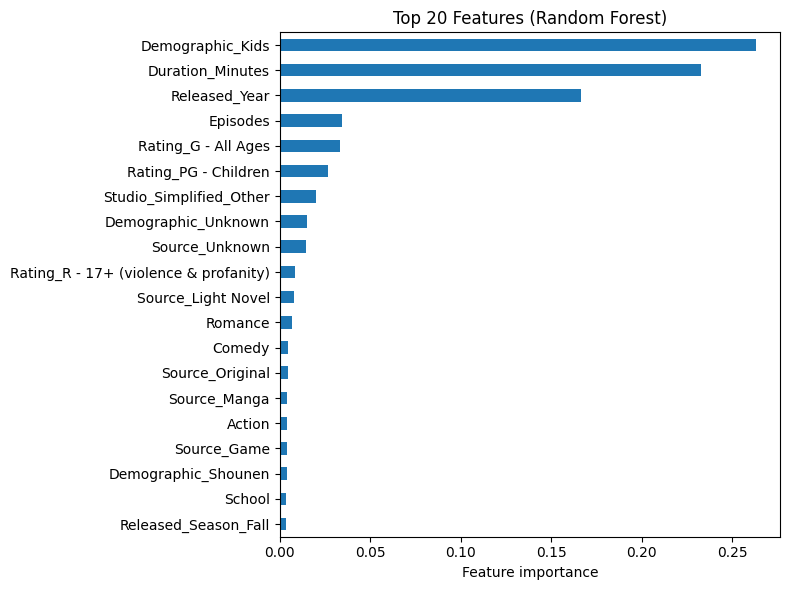

In [30]:
plt.figure(figsize=(8, 6))
top_importances.sort_values().plot(kind="barh")
plt.xlabel("Feature importance")
plt.title("Top 20 Features (Random Forest)")
plt.tight_layout()
plt.show()

### Case study: Medalist

The model is now applied to Medalist entries in the dataset. The resulting predictions represent baseline expectations based on metadata alone. This allows comparison between observed popularity and the values predicted by the model.

Season 1 of Medalist has approximately 75,291 Members, while the model estimates about 54,531. The observed value exceeds the predicted baseline by a sizeable margin, which is consistent with its reputation as a breakout title.

For the second Medalist entry, the model predicts approximately 26,488 Members. This estimate should be interpreted as a lower bound. Sequels often benefit from the accumulated audience of earlier seasons and can exceed the baseline substantially.


In [31]:
#These numbers are the MAL website IDs for Medalist
medalist_ids= [55318, 61335]

medalist_rows= df_model[df_model["myanimelist_id"].isin(medalist_ids)]
medalist_rows_display= medalist_rows[[
    "myanimelist_id", "Type", "Episodes", "Released_Season", "Released_Year",
    "Source", "Genres", "Themes", "Demographic", "Rating", "Studio_Simplified", "Members"
]]

medalist_rows_display

,myanimelist_id,Type,Episodes,Released_Season,Released_Year,Source,Genres,Themes,Demographic,Rating,Studio_Simplified,Members
17247,55318,Tv,13.0,Winter,2025,Manga,"Drama, Sports",Performing Arts,Seinen,PG-13 - Teens 13 or older,Other,73711.0
19337,61335,Tv,13.0,Winter,2026,Manga,"Drama, Sports",Performing Arts,Seinen,PG-13 - Teens 13 or older,Other,15216.0


In [32]:
medalist_X= X.loc[medalist_rows.index]
medalist_log_preds= rf.predict(medalist_X)
medalist_member_preds= np.expm1(medalist_log_preds)


# I map the titles for Medalist to their respective IDs to make the output readable, since the title was removed earlier

title_lookup= {
    55318: "Medalist",
    61335: "Medalist 2nd Season"
}

for idx, row_idx in enumerate(medalist_rows.index):
    mid = df_model.loc[row_idx, "myanimelist_id"]
    title = title_lookup.get(mid, "Unknown Title")
    pred = medalist_member_preds[idx]
    print(f"{title}: predicted Members ≈ {pred:.0f}")


Medalist: predicted Members ≈ 64058
Medalist 2nd Season: predicted Members ≈ 16224


### Conclusion

This notebook shows that structured anime metadata provides enough information to approximate audience size with reasonable accuracy. The Random Forest model identifies several consistent predictors, including demographic targeting, release timing, and studio identity.

Applying the model to Medalist shows that its popularity exceeds the level predicted by metadata alone, with a prediction of 64,058 and an actual of 75,291. This suggests that Medalist achieved its status through factors not present in the dataset, such as strong narrative appeal, community enthusiasm, or favorable word of mouth. For this reason, the prediction for Season 2 could be viewed as a lower bound instead of a true forecast. A model that relies only on metadata cannot measure the momentum created by a strong first season, so sequels often receive conservative estimates even when the franchise is growing.
